In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.5 MB/s eta 0:00:00


In [ ]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 3. Định nghĩa tham số đầu vào
P_max       = 500000                 # Wh, dung lượng tối đa pin
SoC_down    = 10                     # %, ngưỡng SoC thấp nhất
SoC_up      = 95                     # %, ngưỡng SoC cao nhất
P_PCS       = 90                    # %, công suất PCS tối đa so với P_max
eta         = 0.95                   # hiệu suất sạc/xả
P_bat_min   = P_max * SoC_down/100   # Wh, ngưỡng pin tối thiểu (10%)
P_bat_max   = P_max * SoC_up/100     # Wh, ngưỡng pin tối đa (95%)

In [ ]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
pv_df = pd.read_csv("pv_1month_irradiance.csv", parse_dates=["Hour"])
load_df = pd.read_csv("load_demand_hourly.csv", parse_dates=["Hour"])
price_df = pd.read_csv("TOU_price.csv")

# Đổi Start/End thành giờ dạng số nguyên
def extract_hour(time_str):
    return int(time_str.split(":")[0])

price_df["Start_hour"] = price_df["Start"].apply(extract_hour)
price_df["End_hour"] = price_df["End"].apply(extract_hour)

# Hàm lấy giá theo từng giờ
def get_price_for_hour(hour):
    for _, row in price_df.iterrows():
        start = row["Start_hour"]
        end = row["End_hour"]
        if start < end:
            if start <= hour <= end:
                return row["Rate"]
        else:
            if hour >= start or hour <= end:
                return row["Rate"]
    return 0.12  # fallback

# ==== CHỌN NGÀY BẮT ĐẦU ====
start_day = pd.to_datetime("2023-11-01")
end_day = start_day + pd.Timedelta(days=7)

# Lọc theo khoảng thời gian
pv_week = pv_df[(pv_df["Hour"] >= start_day) & (pv_df["Hour"] <= end_day)]
load_week = load_df[(load_df["Hour"] >= start_day) & (load_df["Hour"] <= end_day)]

# Tạo 3 biến như bạn đã dùng:
P_solar = (pv_week["PV Output (kW)"].to_numpy() * 1000).astype(float)  # W
demand = (load_week["Load (kW)"].to_numpy() * 1000).astype(float)      # W
price = np.array([get_price_for_hour(ts.hour) for ts in pv_week["Hour"]])  # USD/kWh
hours = range(len(P_solar))
# Kiểm tra kết quả
print("Số phần tử:", len(P_solar), len(demand), len(price))
print("Giờ đầu tiên:", pv_week["Hour"].iloc[0])
print("Giờ cuối cùng:", pv_week["Hour"].iloc[-1])

Số phần tử: 169 169 169
Giờ đầu tiên: 2023-11-01 00:00:00
Giờ cuối cùng: 2023-11-08 00:00:00


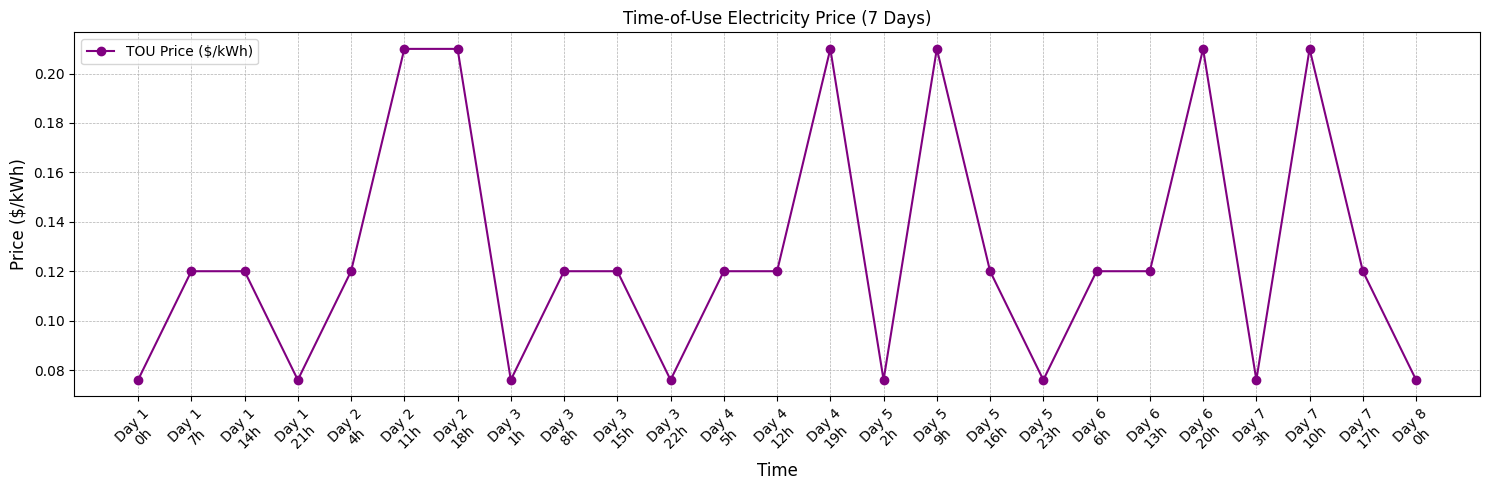

In [ ]:
sample_interval = 7  # Lấy mẫu mỗi giờ

# Danh sách giờ
hours = list(range(len(price)))

# Lấy mẫu dữ liệu
sampled_hours = list(range(0, len(price), sample_interval))
sampled_price = [price[t] for t in sampled_hours]

# Tạo nhãn trục X: Day i \n xxh
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(sampled_hours, sampled_price, label="TOU Price ($/kWh)", marker='o', linestyle='-', color='purple')

plt.title(f"Time-of-Use Electricity Price ({day - 1} Day{'s' if day > 2 else ''})")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($/kWh)", fontsize=12)

plt.xticks(sampled_hours, sampled_labels, rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### **GRID+PV+BESS**

In [ ]:
# 4. Khởi tạo mô hình tối ưu hóa
model = pulp.LpProblem("Microgrid_Cost_Minimization_Day1", pulp.LpMinimize)

In [ ]:
# 5. Khai báo biến quyết định
P_bat         = pulp.LpVariable.dicts("P_bat",          hours, lowBound=P_bat_min, upBound=P_bat_max, cat='Continuous')
P_solar_charge = pulp.LpVariable.dicts("P_solar_charge", hours, lowBound=0,      cat='Continuous')
P_grid_charge  = pulp.LpVariable.dicts("P_grid_charge",  hours, lowBound=0,      cat='Continuous')
P_grid_use_demand    = pulp.LpVariable.dicts("P_grid_use_demand",     hours, lowBound=0,      cat='Continuous')
P_discharge   = pulp.LpVariable.dicts("P_discharge",    hours, lowBound=0,      cat='Continuous')
P_solar_use_demand = pulp.LpVariable.dicts("P_solar_use_demand", hours, lowBound=0, cat="Continuous")

In [ ]:
# 6. Ràng buộc
# (25) P_min ≤ P_bat[t] ≤ P_max
for t in hours:
    model += P_bat[t] >= P_bat_min, f"Battery_Min_{t}"
    model += P_bat[t] <= P_bat_max, f"Battery_Max_{t}"
for t in hours:
    if t == 0:
        model += P_bat[0] == P_bat_min, f"Init_Battery_Level_{t}"
    else:
        model += (P_bat[t] == P_bat[t-1] + eta * (P_grid_charge[t-1] + P_solar_charge[t-1]) - P_discharge[t-1] * (1.0/eta)), f"Battery_Update_{t}"

# (26) P_solar_charge[t] ≤ P_PCS * P_max
#for t in hours:
#    model += P_solar_charge[t] <= (P_PCS/100) * P_max, f"PCS_Limit_{t}"
# (28-29):
for t in hours:
    model += (P_grid_charge[t] + P_solar_charge[t]) <= (P_PCS/100) * P_max, f"Charge_Limit_{t}"
    model += P_discharge[t] <= (P_PCS/100) * P_max, f"Discharge_Limit_{t}"

# (27) P_solar_charge[t] + P_solar_use_demand[t] ≤ P_solar[t]
#for t in hours:
#    model += P_solar_charge[t] <= P_solar[t], f"Solar_Limit_{t}"

for t in hours:
    model += (P_solar_use_demand[t] + P_solar_charge[t] <= P_solar[t]), f"PV_Total_Limit_{t}"

# (30) Cân bằng phụ tải:
#  P_grid_use[t] + P_discharge[t] + (P_solar[t] - P_solar_charge[t]) == demand[t]
#for t in hours:
#    model += (P_grid_use[t] + P_discharge[t]  + (P_solar[t] - P_solar_charge[t])  == demand[t]), f"Load_Balance_{t}"
for t in hours:
    model += (P_grid_use_demand[t] + P_discharge[t] + P_solar_use_demand[t] == demand[t]), f"Load_Balance_{t}"



In [ ]:
# 7. Hàm mục tiêu: Tối thiểu hóa chi phí mua điện từ lưới
# Đổi đơn vị USD/kWh → USD/Wh
price_per_Wh = price / 1000
model += pulp.lpSum([price_per_Wh[t] * (P_grid_use_demand[t] + P_grid_charge[t])
    for t in hours
]), "Total_Grid_Cost"

In [ ]:
# 8. Giải bài toán
model.solve()

1

In [ ]:
# Sau khi model.solve()

status = pulp.LpStatus[model.status]
print("Status:", status)
if status != "Optimal":
    print("Warning: model did not find an optimal solution.")

# Hàm phụ để lấy giá trị, chuyển None → 0
def safe_val(x):
    return x.varValue if x.varValue is not None else 0.0

# In kết quả cho mỗi giờ
for t in hours:
    bat   = safe_val(P_bat[t])
    solCh = safe_val(P_solar_charge[t])
    grdCh = safe_val(P_grid_charge[t])
    dis   = safe_val(P_discharge[t])
    grdUs = safe_val(P_grid_use_demand[t])
    solUs = safe_val(P_solar_use_demand[t])
    dm = demand[t]
    print(f"Hour {t:02d}: Bat={bat:.1f}W | SolarCh={solCh:.1f}W | "
          f"GridCh={grdCh:.1f}W | Disch={dis:.1f}W | GridUse={grdUs:.1f}W |SolarUseDemand={solUs:.1f}W| Demand={dm:.1f}W")


Status: Optimal
Hour 00: Bat=50000.0W | SolarCh=0.0W | GridCh=447368.4W | Disch=0.0W | GridUse=60466.8W |SolarUseDemand=0.0W| Demand=60466.8W
Hour 01: Bat=475000.0W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=56620.6W |SolarUseDemand=0.0W| Demand=56620.6W
Hour 02: Bat=475000.0W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=79444.9W |SolarUseDemand=0.0W| Demand=79444.9W
Hour 03: Bat=475000.0W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=67088.4W |SolarUseDemand=0.0W| Demand=67088.4W
Hour 04: Bat=475000.0W | SolarCh=0.0W | GridCh=0.0W | Disch=5774.6W | GridUse=58507.2W |SolarUseDemand=0.0W| Demand=64281.7W
Hour 05: Bat=468921.5W | SolarCh=0.0W | GridCh=0.0W | Disch=59309.6W | GridUse=0.0W |SolarUseDemand=0.0W| Demand=59309.6W
Hour 06: Bat=406490.4W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=55674.5W |SolarUseDemand=0.0W| Demand=55674.5W
Hour 07: Bat=406490.4W | SolarCh=72115.4W | GridCh=0.0W | Disch=0.0W | GridUse=0.0W |SolarUseDemand=119951.5W| Demand=11995

In [ ]:
# Tính chi phí khi dùng microgrid (đã tối ưu)
cost_microgrid = sum([
    price_per_Wh[t] * (safe_val(P_grid_use_demand[t]) + safe_val(P_grid_charge[t]))
    for t in hours
])
# In kết quả
print(f"Chi phí khi dùng microgrid:        {cost_microgrid:.2f} USD")

Chi phí khi dùng microgrid:        1346.37 USD


### **GRID+PV**

In [ ]:
# 2. PV + NỐI LƯỚI – KHÔNG BESS
model_pv_grid = pulp.LpProblem("PV_Grid_Cost_Minimization", pulp.LpMinimize)

# Biến quyết định: điện mua từ lưới
P_grid_use_pv = pulp.LpVariable.dicts("P_grid_use_pv", hours, lowBound=0, cat='Continuous')

# Ràng buộc: cân bằng tải
for t in hours:
    # PV dùng trực tiếp cho tải, phần còn lại lấy từ lưới
    pv_to_load = min(P_solar[t], demand[t])
    model_pv_grid += P_grid_use_pv[t] + pv_to_load == demand[t], f"Load_Balance_PVGrid_{t}"

# Hàm mục tiêu: tối thiểu hóa chi phí mua điện từ lưới
model_pv_grid += pulp.lpSum([price_per_Wh[t] * P_grid_use_pv[t] for t in hours]), "Total_PV_Grid_Cost"

# Giải bài toán
model_pv_grid.solve()
status = pulp.LpStatus[model_pv_grid.status]
print("Status:", status)
print("\n=== Kết quả: PV + NỐI LƯỚI ===")
for t in hours:
    pv_to_load = min(P_solar[t], demand[t])
    grid = safe_val(P_grid_use_pv[t])
    print(f"Hour {t:02d}: PVtoLoad={pv_to_load:.1f}Wh | GridUse={grid:.1f}Wh")

cost_pv_grid = sum([price_per_Wh[t] * safe_val(P_grid_use_pv[t]) for t in hours])
print(f"→ Tổng chi phí (PV + lưới): {cost_pv_grid:.2f} USD")

Status: Optimal

=== Kết quả: PV + NỐI LƯỚI ===
Hour 00: PVtoLoad=0.0Wh | GridUse=60466.8Wh
Hour 01: PVtoLoad=0.0Wh | GridUse=56620.6Wh
Hour 02: PVtoLoad=0.0Wh | GridUse=79444.9Wh
Hour 03: PVtoLoad=0.0Wh | GridUse=67088.4Wh
Hour 04: PVtoLoad=0.0Wh | GridUse=64281.7Wh
Hour 05: PVtoLoad=0.0Wh | GridUse=59309.6Wh
Hour 06: PVtoLoad=0.0Wh | GridUse=55674.5Wh
Hour 07: PVtoLoad=119951.5Wh | GridUse=0.0Wh
Hour 08: PVtoLoad=164786.8Wh | GridUse=84197.7Wh
Hour 09: PVtoLoad=175794.8Wh | GridUse=96910.6Wh
Hour 10: PVtoLoad=105038.6Wh | GridUse=139304.0Wh
Hour 11: PVtoLoad=202743.1Wh | GridUse=28767.7Wh
Hour 12: PVtoLoad=140347.0Wh | GridUse=0.0Wh
Hour 13: PVtoLoad=124773.9Wh | GridUse=60378.5Wh
Hour 14: PVtoLoad=121633.4Wh | GridUse=123472.4Wh
Hour 15: PVtoLoad=121796.0Wh | GridUse=101294.5Wh
Hour 16: PVtoLoad=134232.6Wh | GridUse=83349.4Wh
Hour 17: PVtoLoad=156927.9Wh | GridUse=37459.1Wh
Hour 18: PVtoLoad=0.0Wh | GridUse=149359.7Wh
Hour 19: PVtoLoad=0.0Wh | GridUse=111706.0Wh
Hour 20: PVtoLoad=0.

### **GRID_ONLY**

In [ ]:
# 1. CHỈ NỐI LƯỚI – KHÔNG PV, KHÔNG BESS
model_grid_only = pulp.LpProblem("Grid_Only_Cost_Minimization", pulp.LpMinimize)

# Biến quyết định: chỉ có P_grid_use
P_grid_use_only = pulp.LpVariable.dicts("P_grid_use_only", hours, lowBound=0, cat='Continuous')

# Ràng buộc: phụ tải hoàn toàn đến từ lưới
for t in hours:
    model_grid_only += P_grid_use_only[t] == demand[t], f"Load_Balance_GridOnly_{t}"

# Hàm mục tiêu: tối thiểu hóa chi phí từ lưới
model_grid_only += pulp.lpSum([price_per_Wh[t] * P_grid_use_only[t] for t in hours]), "Total_Grid_Only_Cost"

# Giải bài toán
model_grid_only.solve()

print("\n=== Kết quả: CHỈ NỐI LƯỚI ===")
for t in hours:
    grid = safe_val(P_grid_use_only[t])
    print(f"Hour {t:02d}: GridUse={grid:.1f}Wh")

cost_grid_only = sum([price_per_Wh[t] * safe_val(P_grid_use_only[t]) for t in hours])
print(f"→ Tổng chi phí (chỉ lưới): {cost_grid_only:.2f} USD")


=== Kết quả: CHỈ NỐI LƯỚI ===
Hour 00: GridUse=60466.8Wh
Hour 01: GridUse=56620.6Wh
Hour 02: GridUse=79444.9Wh
Hour 03: GridUse=67088.4Wh
Hour 04: GridUse=64281.7Wh
Hour 05: GridUse=59309.6Wh
Hour 06: GridUse=55674.5Wh
Hour 07: GridUse=119951.5Wh
Hour 08: GridUse=248984.4Wh
Hour 09: GridUse=272705.4Wh
Hour 10: GridUse=244342.5Wh
Hour 11: GridUse=231510.8Wh
Hour 12: GridUse=140347.0Wh
Hour 13: GridUse=185152.4Wh
Hour 14: GridUse=245105.8Wh
Hour 15: GridUse=223090.5Wh
Hour 16: GridUse=217582.0Wh
Hour 17: GridUse=194387.0Wh
Hour 18: GridUse=149359.7Wh
Hour 19: GridUse=111706.0Wh
Hour 20: GridUse=74619.3Wh
Hour 21: GridUse=83764.5Wh
Hour 22: GridUse=78802.9Wh
Hour 23: GridUse=62131.5Wh
Hour 24: GridUse=57358.7Wh
Hour 25: GridUse=55579.9Wh
Hour 26: GridUse=55653.7Wh
Hour 27: GridUse=55032.8Wh
Hour 28: GridUse=54115.6Wh
Hour 29: GridUse=54775.9Wh
Hour 30: GridUse=51178.1Wh
Hour 31: GridUse=54174.5Wh
Hour 32: GridUse=58751.9Wh
Hour 33: GridUse=70591.9Wh
Hour 34: GridUse=67935.5Wh
Hour 35: Gr

In [ ]:

print(f"→ Tổng chi phí (chỉ lưới): {cost_grid_only:.2f} USD")
print(f"→ Tổng chi phí (PV + lưới): {cost_pv_grid:.2f} USD")
print(f"→ Chi phí khi dùng microgrid: {cost_microgrid:.2f} USD")


→ Tổng chi phí (chỉ lưới): 3336.69 USD
→ Tổng chi phí (PV + lưới): 1871.79 USD
→ Chi phí khi dùng microgrid: 1346.37 USD


### **COMPARE 3 MODELS**

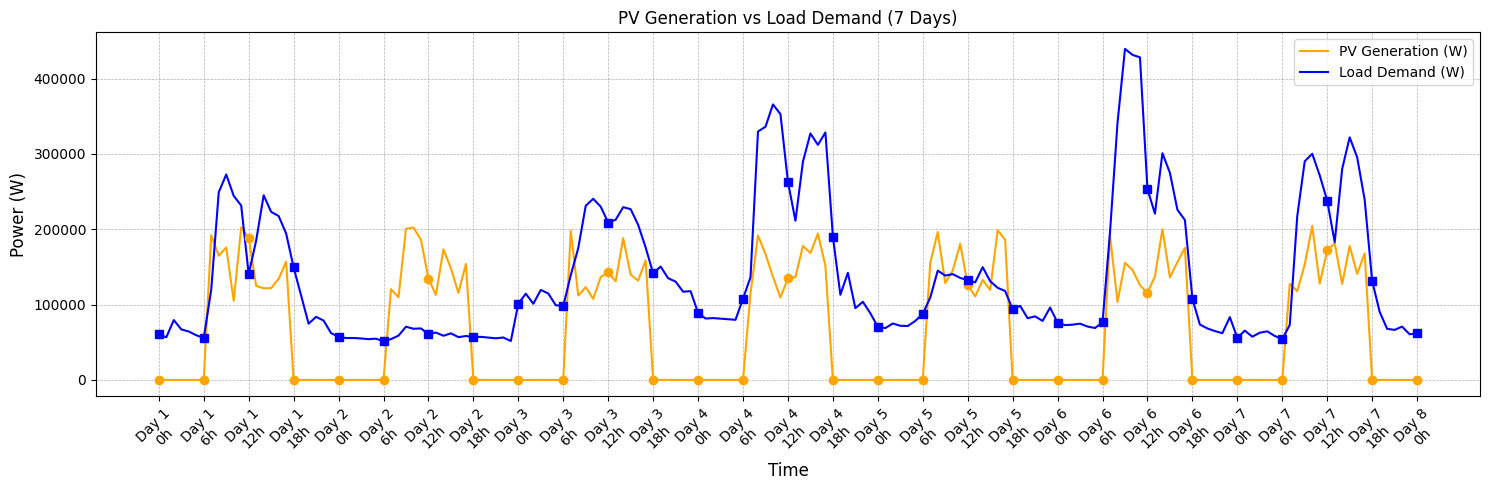

In [ ]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_yaxis(value, _):
    return f'{int(value)}'
sample_interval = 1  # Lấy dữ liệu mỗi 1 giờ
marker_interval = 6  # Marker mỗi 6 giờ

solar_vals = [P_solar[t] for t in hours]
demand_vals = [demand[t] for t in hours]

sampled_hours = list(range(0, len(P_solar), sample_interval))
sampled_solar = [solar_vals[t] for t in sampled_hours]
sampled_demand = [demand_vals[t] for t in sampled_hours]

# Marker mỗi 6 giờ
marker_hours = sampled_hours[::marker_interval]
marker_solar = [solar_vals[t] for t in marker_hours]
marker_demand = [demand[t] for t in marker_hours]

# Nhãn trục X
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

xtick_interval = 6
xtick_positions = sampled_hours[::xtick_interval]
xtick_labels = [sampled_labels[i] for i in range(0, len(sampled_labels), xtick_interval)]

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))

# Vẽ đường liên tục không marker
plt.plot(sampled_hours, sampled_solar, label="PV Generation (W)", linestyle='-', color='orange')
plt.plot(sampled_hours, sampled_demand, label="Load Demand (W)", linestyle='-', color='blue')

# Vẽ marker tại mỗi 6 giờ
plt.plot(marker_hours, marker_solar, 'o', color='orange')
plt.plot(marker_hours, marker_demand, 's', color='blue')

plt.title(f"PV Generation vs Load Demand ({day-1} Day{'s' if day > 2 else ''})")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (W)", fontsize=12)
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.tight_layout()
plt.show()

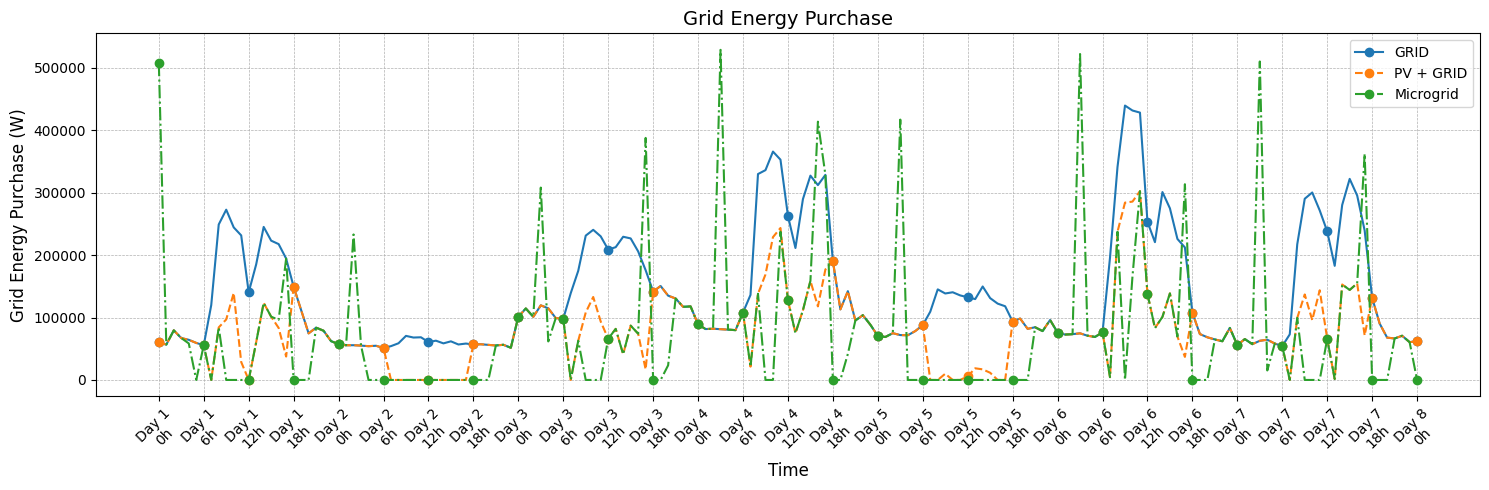

In [ ]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_yaxis(value, _):
    return f'{int(value)}'  # Hiện số đầy đủ, không dấu phẩy

sample_interval = 1  # Giữ nguyên lấy mẫu mỗi giờ
plot_interval = 6    # Mỗi 6 giờ vẽ 1 marker, label và grid

# Dữ liệu đầu vào
grid_use_only_vals = [safe_val(P_grid_use_only[t]) for t in hours]
grid_use_pv_vals = [safe_val(P_grid_use_pv[t]) for t in hours]
grid_use_micro_vals = [safe_val(P_grid_use_demand[t]) + safe_val(P_grid_charge[t]) for t in hours]

# Lấy mẫu đầy đủ (vẫn mỗi giờ, để giữ đủ dữ liệu vẽ)
sampled_hours = list(range(0, len(P_solar), sample_interval))
sampled_grid_use_only = [grid_use_only_vals[t] for t in sampled_hours]
sampled_grid_use_pv = [grid_use_pv_vals[t] for t in sampled_hours]
sampled_grid_use_micro = [grid_use_micro_vals[t] for t in sampled_hours]

# Tạo nhãn trục X
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

# Tạo vị trí vẽ nhãn và grid mỗi 6 giờ
xtick_positions = sampled_hours[::plot_interval]
xtick_labels = [sampled_labels[i] for i in range(0, len(sampled_labels), plot_interval)]

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(sampled_hours, sampled_grid_use_only, label="GRID", linestyle='-', marker='o', markevery=plot_interval)
plt.plot(sampled_hours, sampled_grid_use_pv, label="PV + GRID", linestyle='--', marker='o', markevery=plot_interval)
plt.plot(sampled_hours, sampled_grid_use_micro, label="Microgrid", linestyle='-.', marker='o', markevery=plot_interval)

plt.title("Grid Energy Purchase", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Grid Energy Purchase (W)", fontsize=12)

# Gán nhãn và grid X mỗi 6 giờ
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Format trục Y không dấu phẩy, không dạng 1e6
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.legend()
plt.tight_layout()
plt.show()


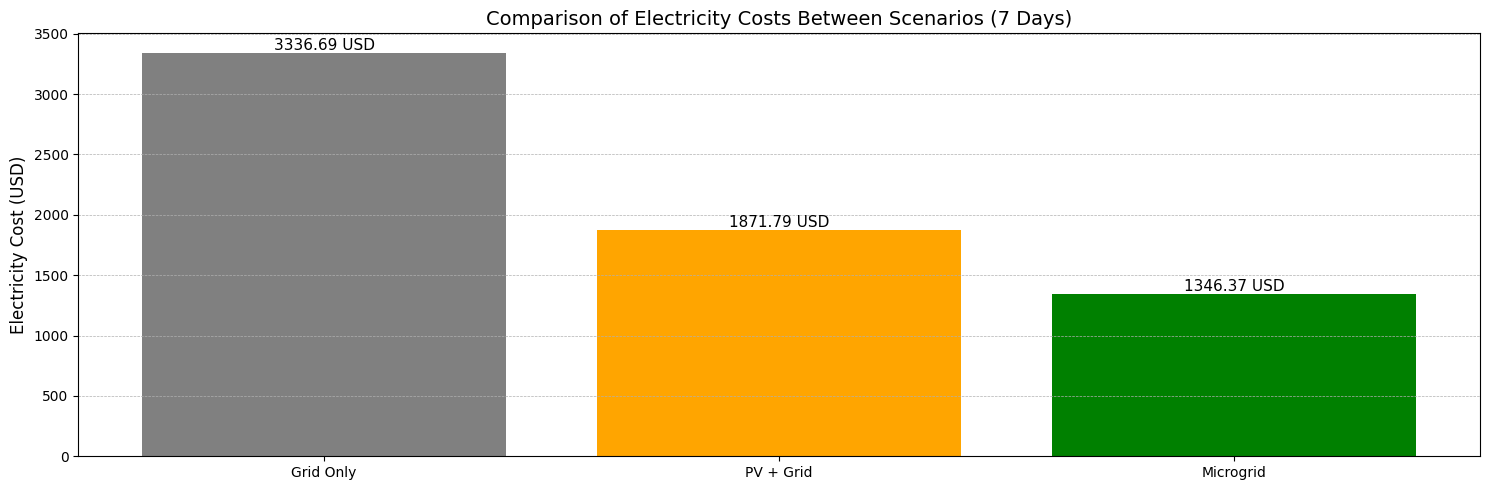

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các kịch bản và chi phí tương ứng
scenarios = ["Grid Only", "PV + Grid", "Microgrid"]
costs = [cost_grid_only, cost_pv_grid, cost_microgrid]

# Vẽ biểu đồ cột
plt.figure(figsize=(15, 5))
bars = plt.bar(scenarios, costs, color=["gray", "orange", "green"])

# Hiển thị giá trị chi phí trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
             f"{height:.2f} USD", ha='center', va='bottom', fontsize=11)

# Cài đặt đồ thị
plt.title("Comparison of Electricity Costs Between Scenarios (7 Days)", fontsize=14)
plt.ylabel("Electricity Cost (USD)", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Tổng phụ tải (demand)
total_demand = np.sum(demand) / 1000  # kW

# 2. Tổng công suất mặt trời (P_solar)
total_p_solar = np.sum(P_solar) / 1000  # kW

# 3, 4, 5, 6 cho từng trường hợp

# Trường hợp 1: Microgrid (GRID + PV + BESS)
total_grid_use_microgrid = sum(safe_val(P_grid_use_demand[t]) for t in hours) / 1000
total_grid_charge_microgrid = sum(safe_val(P_grid_charge[t]) for t in hours) / 1000
total_solar_charge_microgrid = sum(safe_val(P_solar_charge[t]) for t in hours) / 1000
total_pv_to_load_microgrid = sum(safe_val(P_solar_use_demand[t]) for t in hours) / 1000
total_discharge_microgrid = sum(safe_val(P_discharge[t]) for t in hours) / 1000
total_cost_microgrid = cost_microgrid

# Trường hợp 2: Chỉ nối lưới (GRID ONLY)
total_grid_use_gridonly = sum(safe_val(P_grid_use_only[t]) for t in hours) / 1000
total_cost_gridonly = cost_grid_only

# Trường hợp 3: PV + nối lưới (GRID + PV, không BESS)
total_grid_use_pvgrid = sum(safe_val(P_grid_use_pv[t]) for t in hours) / 1000
total_pv_to_load_pvgrid = sum(min(P_solar[t], demand[t]) for t in hours) / 1000
total_cost_pvgrid = cost_pv_grid

# In kết quả
print("\n===== Tổng hợp kết quả =====")
print(f"Tổng phụ tải (demand): {total_demand:.1f} kW")
print(f"Tổng công suất mặt trời (P_solar): {total_p_solar:.1f} kW")

print("\n-- Trường hợp Microgrid (GRID+PV+BESS) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_microgrid + total_grid_charge_microgrid:.1f} kW")
print(f"Tổng lượng điện mặt trời dùng cho tải: {total_pv_to_load_microgrid:.1f} kW")
print(f"Tổng lượng pin đã được sạc: {total_grid_charge_microgrid + total_solar_charge_microgrid:.1f} kW")
print(f"Tổng lượng pin dùng cho tải : {total_discharge_microgrid:.1f} kW")
print(f"Tổng chi phí: {total_cost_microgrid:.2f} USD")

print("\n-- Trường hợp Chỉ nối lưới (GRID ONLY) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_gridonly:.1f} kW")
print(f"Tổng chi phí: {total_cost_gridonly:.2f} USD")

print("\n-- Trường hợp PV + nối lưới (GRID + PV, không BESS) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_pvgrid:.1f} kW")
print(f"Tổng lượng điện mặt trời dùng cho tải: {total_pv_to_load_pvgrid:.1f} kW")
print(f"Tổng chi phí: {total_cost_pvgrid:.2f} USD")



===== Tổng hợp kết quả =====
Tổng phụ tải (demand): 23608.6 kW
Tổng công suất mặt trời (P_solar): 11620.0 kW

-- Trường hợp Microgrid (GRID+PV+BESS) --
Tổng lượng điện mua từ lưới: 12947.8 kW
Tổng lượng điện mặt trời dùng cho tải: 9098.7 kW
Tổng lượng pin đã được sạc: 5028.6 kW
Tổng lượng pin dùng cho tải : 4600.3 kW
Tổng chi phí: 1346.37 USD

-- Trường hợp Chỉ nối lưới (GRID ONLY) --
Tổng lượng điện mua từ lưới: 23608.6 kW
Tổng chi phí: 3336.69 USD

-- Trường hợp PV + nối lưới (GRID + PV, không BESS) --
Tổng lượng điện mua từ lưới: 13492.1 kW
Tổng lượng điện mặt trời dùng cho tải: 10116.5 kW
Tổng chi phí: 1871.79 USD
